In [1]:
# we will also remove dropout from our ResNet50 model and run again
# to see if we can also improve the training vs validation curves
# as in the previous notebook with vgg16, architecturally
# also note we have to increase in the number of units and dense layers
# prior to the softmax layer in the head model

# Let's first import all necessary libraries

import tensorflow as tf
print(tf.__version__)

2.4.0


In [2]:
import pandas as pd
import numpy as np

In [3]:
# mount drive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# previously constructed dataframes that split the data

training_covid = pd.read_csv('/gdrive/My Drive/training_covid')
validation_covid = pd.read_csv('/gdrive/My Drive/validation_covid')
X_test_covid = pd.read_csv('/gdrive/My Drive/X_test_covid')
y_test_covid = pd.read_csv('/gdrive/My Drive/y_test_covid')

In [5]:
testing_covid = pd.concat([X_test_covid, y_test_covid], axis=1)

In [6]:
# Now we create generators without the original class imbalance and with
# The normalized features, with 0 mean and a standard deviation of 1

import os
from keras.preprocessing.image import ImageDataGenerator

# Recall that the images were moved to a folder names XRays. 
image_dir = '/gdrive/My Drive/XRays'

In [7]:

def get_train_generator(train_df, image_dir, x_col, y_col, shuffle=True, batch_size=8, target_w = 224, target_h = 224):
  """
  Return generator for training set, normalizing using batch
  statistics.

  Args:
    train_df (dataframe): dataframe specifying training data.
    image_dir (str): directory where image files are held.
    x_col (str): name of column in df that holds filenames.
    y_cols (list): list of strings that hold y labels for images.
    batch_size (int): images per batch to be fed into model during training.
    seed (int): random seed.
    target_w (int): final width of input images.
    target_h (int): final height of input images.
    
    Returns:
      train_generator (DataFrameIterator): iterator over training set
    """ 
  # The folder contains a subfolder for each class of shape
    
  classes = sorted(os.listdir(image_dir))
  print(classes)
  train_datagen = ImageDataGenerator(samplewise_center=True, # Set each sample mean to 0 
                             samplewise_std_normalization=True, # Divide each input by its standard deviation
  )

  print("Preparing training dataset...\n")

  # Flow from directory with specified batch size and target image size
  train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='/gdrive/My Drive/XRaysCombo',
        x_col=x_col, # features
        y_col=y_col, # labels
        class_mode='categorical', # 3 classes
        batch_size= batch_size, # images per batch
        shuffle=shuffle, # shuffle the rows or not
        target_size=(target_w, target_h) # width and height of output image this one matches RESNET50
  )
  return train_generator

In [8]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_col, sample_batch_size=305, batch_size=8, target_w = 224, target_h = 224):
  """
  Return generator for validation set and test test set using 
  normalization statistics from training set.

  Args:
    valid_df (dataframe): dataframe specifying validation data.
    test_df (dataframe): dataframe specifying test data.
    train_df (dataframe): dataframe specifying training data.
    image_dir (str): directory where image files are held.
    x_col (str): name of column in df that holds filenames.
    y_cols (list): list of strings that hold y labels for images.
    sample_size (int): size of sample to use for normalization statistics.
    batch_size (int): images per batch to be fed into model during training.
    seed (int): random seed.
    target_w (int): final width of input images.
    target_h (int): final height of input images.
    
  Returns:
      test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """

  # create validation set using normalization statistics from
  # the training set only

  print("\nSampling normalization statistics from training only...\n")

  
  
  # Flow from directory with specified batch size and target image size
  sample_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory='/gdrive/My Drive/XRaysCombo',
        x_col=x_col, # features
        y_col=y_col, # labels
        class_mode='categorical', # 3 classes
        batch_size= batch_size, # images per batch
        shuffle=True, # shuffle the rows or not
        target_size=(target_w, target_h) # width and height of output image this one matches RESNET50
  
  )
  # get data sample
  batch = sample_generator.next()
  data_sample = batch[0]


  # generator fitted with training set only

  # use sample to fit mean and std for test set generator
  test_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
  
  test_datagen.fit(data_sample)


  print("\nPreparing validation dataset...\n")

  # Flow from directory with specified batch size and target image size
  validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory='/gdrive/My Drive/XRaysCombo',
        x_col=x_col, # features
        y_col= y_col, # labels
        class_mode='categorical', # 3 classes
        batch_size= batch_size, # images per batch
        shuffle=False, # shuffle the rows or not
        target_size=(target_w, target_h) # width and height of output image this one matches RESNET50
  )

  print("\nPreparing testing dataset...\n")

  # Flow from directory with specified batch size and target image size
  test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='/gdrive/My Drive/XRaysCombo',
        x_col=x_col, # features
        y_col=y_col, # labels
        class_mode='categorical', # 3 classes
        batch_size= batch_size, # images per batch
        shuffle=False, # shuffle the rows or not
        target_size=(target_w, target_h) # width and height of output image this one matches RESNET50
  )
  return validation_generator, test_generator

In [9]:
train_df = training_covid 
valid_df = validation_covid
test_df = testing_covid
x_col = "FILE NAME"
y_col = 'Class'

train_generator = get_train_generator(train_df, image_dir, x_col, y_col)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_col)

['COVID-19', 'Normal', 'Viral Pneumonia']
Preparing training dataset...

Found 305 validated image filenames belonging to 3 classes.

Sampling normalization statistics from training only...

Found 305 validated image filenames belonging to 3 classes.

Preparing validation dataset...

Found 54 validated image filenames belonging to 3 classes.

Preparing testing dataset...

Found 40 validated image filenames belonging to 3 classes.


In [10]:
def create_model():
  """
  This function returns a base ResNet50 transfer learning model trained on
  imagenet connected to a custom head adapted to a 3 class softmax probability
  """
  # we will start by building a ResNet50 model
  # Build model freezing top layers and adding a dense layer 
  # with the number of classes
  model = tf.keras.Sequential()
  # load the ResNet50 network, ensuring the head FC layer sets are left
  # off
  base = tf.keras.applications.ResNet50(weights="imagenet", include_top=False,
	  input_tensor=tf.keras.Input(shape=(224,224,3)))

  # construct the head of the model that will be placed on top of the
  # the base model
  head = base.output
  head = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(head)
  head = tf.keras.layers.Flatten()(head)
  head = tf.keras.layers.Dense(256, activation="relu")(head) # increase units
  head = tf.keras.layers.Dense(512, activation="relu")(head) # increase units
  head = tf.keras.layers.Dense(512, activation="relu")(head) # increase units
  # head = tf.keras.layers.Dropout(0.5)(head) # remove dropout
  head = tf.keras.layers.Dense(3, activation="softmax")(head)

  # place the head FC model on top of the base model (this will become
  # the actual model we will train)
  model = tf.keras.Model(inputs=base.input, outputs=head)

  # loop over all layers in the base model and freeze them
  for layer in base.layers:
	  layer.trainable = False



  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [11]:
# call back to save best weights only (entire model)

def get_checkpoint_best_only_conv():
    """
    This function returns a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    """
    checkpoint_path = '/gdrive/My Drive/covid_resnet50_no_reg.pb'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
        )
  
    return model_checkpoint_callback

In [12]:
# callback to stop training if no further improvement
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) loss has not improved in the last 3 epochs.
    
    """
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=3)

In [13]:
# call back to reduce the learning rate if the model plateaus using recommended parameters
# for the Adam optimizer (reduce_on_plateau)

# call back to reduce the learning rate (lr_schedule) by the function given every epoch
# we can plot the schedule against the loss to set the learning rate

checkpoint_best_only = get_checkpoint_best_only_conv()
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='val_loss', 
                              factor=0.1, patience=2,
                              verbose=1, mode='auto', min_delta=0.0001,
                              cooldown=0, min_lr=0)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))

# at first, set the lr only

callbacks = [lr_schedule]

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# create the model
model = create_model()

# Fit the model to the training data
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=305//8, 
                              validation_steps=54//8, 
                              epochs = 10,
                              callbacks=callbacks)

94773248/94765736 [==============================] - 3s 0us/step
Epoch 1/10
38/38 [==============================] - 173s 4s/step - loss: 0.8910 - accuracy: 0.5709 - val_loss: 0.4709 - val_accuracy: 0.9167
Epoch 2/10
38/38 [==============================] - 7s 196ms/step - loss: 0.6027 - accuracy: 0.7435 - val_loss: 0.3718 - val_accuracy: 0.8958
Epoch 3/10
38/38 [==============================] - 7s 196ms/step - loss: 0.3326 - accuracy: 0.8729 - val_loss: 0.4887 - val_accuracy: 0.8333
Epoch 4/10
38/38 [==============================] - 7s 197ms/step - loss: 0.4169 - accuracy: 0.8397 - val_loss: 0.3091 - val_accuracy: 0.8750
Epoch 5/10
38/38 [==============================] - 8s 203ms/step - loss: 0.3050 - accuracy: 0.9117 - val_loss: 0.4561 - val_accuracy: 0.7708
Epoch 6/10
38/38 [==============================] - 7s 198ms/step - loss: 0.4376 - accuracy: 0.8234 - val_loss: 0.2874 - val_accuracy: 0.8958
Epoch 7/10
38/38 [==============================] - 7s 197ms/step - loss: 0.3280 - a

(0.001, 0.003, 0.0, 2.0)

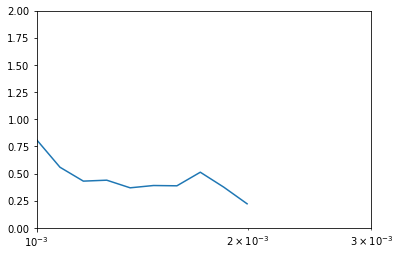

In [15]:
# Check for best rate
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 3*1e-3, 0, 2])

In [16]:
# keep the learning rate at 1e-3 and decrease rate on plateau slightly
# save best model, stop training if no further improvement (early stopping callback)

checkpoint_best_only = get_checkpoint_best_only_conv()
early_stopping = get_early_stopping()
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='val_loss', 
                              factor=0.1, patience=2,
                              verbose=1, mode='auto', min_delta=0.0001,
                              cooldown=0, min_lr=0)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))

# now that the best range for the learning rate is known
# use all callbacks

callbacks = [checkpoint_best_only, early_stopping, reduce_on_plateau]

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# create the model
model = create_model()

# Fit the model to the training data
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=305//8, 
                              validation_steps=54//8, 
                              epochs = 30,
                              callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - 11s 225ms/step - loss: 1.1636 - accuracy: 0.4391 - val_loss: 0.5905 - val_accuracy: 0.7500
INFO:tensorflow:Assets written to: /gdrive/My Drive/covid_resnet50_no_reg.pb/assets
Epoch 2/30
38/38 [==============================] - 8s 200ms/step - loss: 0.5688 - accuracy: 0.8008 - val_loss: 0.5452 - val_accuracy: 0.7917
INFO:tensorflow:Assets written to: /gdrive/My Drive/covid_resnet50_no_reg.pb/assets
Epoch 3/30
38/38 [==============================] - 8s 199ms/step - loss: 0.4331 - accuracy: 0.8287 - val_loss: 0.6600 - val_accuracy: 0.6667
Epoch 4/30
38/38 [==============================] - 8s 205ms/step - loss: 0.3953 - accuracy: 0.8570 - val_loss: 0.3638 - val_accuracy: 0.8958
INFO:tensorflow:Assets written to: /gdrive/My Drive/covid_resnet50_no_reg.pb/assets
Epoch 5/30
38/38 [==============================] - 8s 199ms/step - loss: 0.2615 - accuracy: 0.8856 - val_loss: 0.4034 - val_accuracy: 0.9167
INFO:tensorflow:Assets written to: /g

In [18]:
# note how the model was last saved at at epoch #9 with a validation accuracy of 0.9375
# delete current model variable
del model

In [19]:
from tensorflow.keras.models import load_model

In [30]:
# Reload model from scratch this way we test our saved model

model = load_model('/gdrive/My Drive/covid_resnet50_no_reg.pb')

In [31]:
# predictions with unseen test data
prediction = model.predict(test_generator, steps = len(test_generator))

In [32]:
y_pred = np.argmax(prediction, axis = 1)
y_pred

array([0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 1, 2, 1, 0, 2, 2, 0, 0,
       0, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2])

In [33]:
# make a list of the class names
class_names = ['COVID-19', 'Normal', 'Viral Pneumonia']

In [34]:
# convert test entries to integers for comparison with predictions
classcategories = {'COVID-19': 0,'Normal':1,'Viral Pneumonia':2}
y_test_covid['y_true'] = [classcategories[x] for x in y_test_covid['Class']]
y_test_covid['y_true'].value_counts()

2    14
1    13
0    13
Name: y_true, dtype: int64

In [35]:
# true values
y_test = y_test_covid['y_true'].values
y_test

array([2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 2])

Confusion matrix, without normalization
[[12  0  1]
 [ 0  9  4]
 [ 1  0 13]]
Normalized confusion matrix
[[0.92 0.   0.08]
 [0.   0.69 0.31]
 [0.07 0.   0.93]]


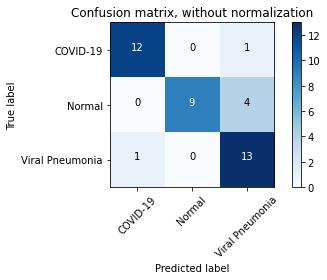

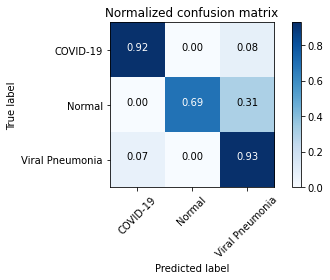

In [36]:
# confusion matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")

In [37]:

# we have one covid 19 misclassified patient as viral pneumonia
# 4 normal patients misclassified as viral pneumonia
# and 1 viral pneumonia patient misclassified as covid 19
# but either way it looks like the vgg16 model is still doing a better job with
# classification with this small amount of data,
# since this is obvious we will not try to further improve
# the model, we can already see that we were able to close
# the gap significantly between the training and test 
# losses but the metrics did not really change that 
# much, there are other things that we can try to do,
# like normalization, but, in the interest of efficient 
# iteration, we know we have a good model, 
# so we are going with the vgg16 model,
# again, of course with the right computation resources
# a cross validation study can also be set up when modeling
# to verify the robustness of the metrics with averages

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

       COVID-19       0.92      0.92      0.92        13
         Normal       1.00      0.69      0.82        13
Viral Pneumonia       0.72      0.93      0.81        14

       accuracy                           0.85        40
      macro avg       0.88      0.85      0.85        40
   weighted avg       0.88      0.85      0.85        40



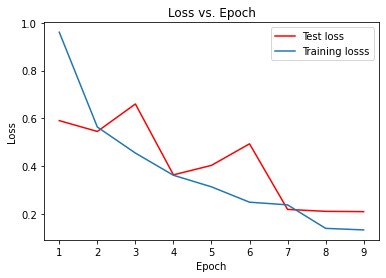

In [40]:
# Visualize training and testing loss (validation set)

def plot_loss(history):
    '''Function to plot the loss vs. epoch'''
    train_loss = history.history['loss'][:9]
    test_loss = history.history['val_loss'][:9]
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red', label = 'Test loss')
    plt.plot(x, train_loss, label = 'Training losss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    
plot_loss(history) 

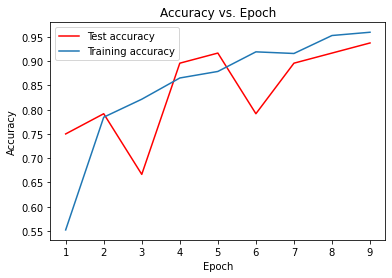

In [41]:
# Visualize training and testing accuracy (validation set)

def plot_accuracy(history):
    train_acc = history.history['accuracy'][:9]
    test_acc = history.history['val_accuracy'][:9]
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'Test accuracy')
    plt.plot(x, train_acc, label = 'Training accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')  
    
plot_accuracy(history) 